<a href="https://colab.research.google.com/github/22bsm056/AI-All-IN-ONE/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ Libraries imported successfully!
Dataset Loaded Successfully!
Dataset Shape: (87780, 13)

Columns: ['Unnamed: 0', 'datadate', 'tic', 'adjcp', 'open', 'high', 'low', 'volume', 'macd', 'rsi', 'cci', 'adx', 'turbulence']

First few rows:
   Unnamed: 0  datadate   tic      adjcp       open       high        low  \
0           0  20090102  AAPL  12.964286  12.268571  13.005714  12.165714   
1           1  20090102   AXP  19.330000  18.570000  19.520000  18.400000   
2           2  20090102    BA  45.250000  42.800000  45.560000  42.780000   
3           3  20090102   CAT  46.910000  44.910000  46.980000  44.710000   
4           4  20090102  CSCO  16.960000  16.410000  17.000000  16.250000   
5           5  20090102   CVX  76.520000  74.230000  77.300000  73.580000   
6           6  20090102    DD  46.234623  45.544554  46.504650  44.254425   
7           7  20090102   DIS  23.920000  22.760000  24.030000  22.500000   
8           8  20090102    GS  86.760000  84.020000  87.620000  82.190

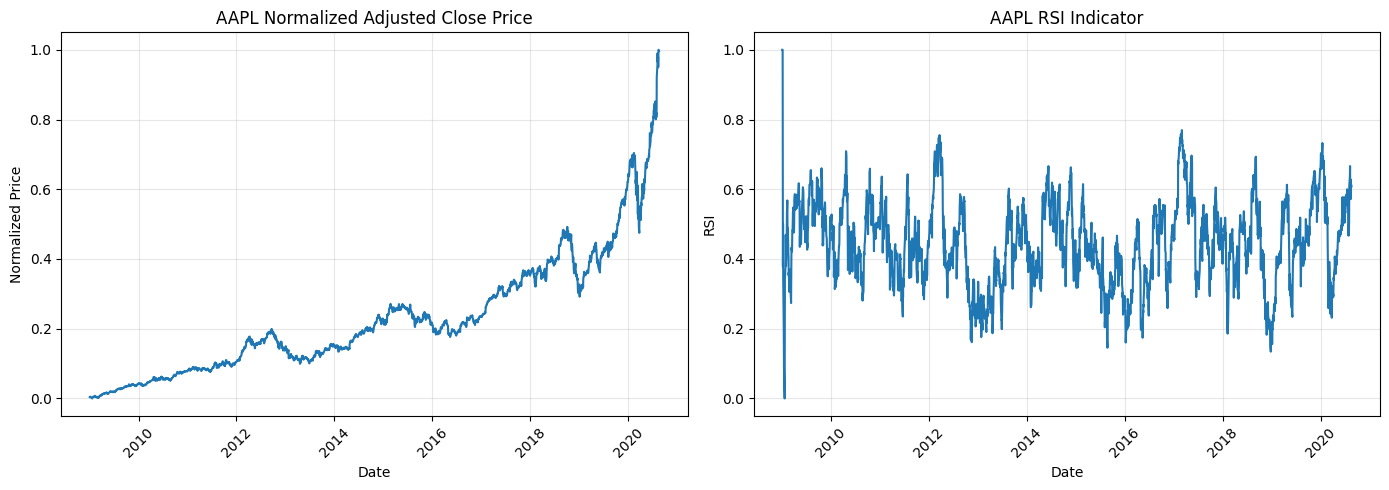

✓ Trading Environment Created!
Environment Details:
  - Actions: 3 (BUY, SELL, HOLD)
  - State Features: 8
  - Initial Balance: $10,000
  - Trading Steps: 2926
✓ Q-Learning Agent Initialized!
Agent Parameters:
  - Learning Rate (α): 0.1
  - Discount Factor (γ): 0.95
  - Initial Epsilon (ε): 1.0
  - Epsilon Decay: 0.995
  - State Bins: 10
Starting Training...
Episode 20/200
  Avg Portfolio Value: $23845.50
  Avg Reward: $13845.50
  Epsilon: 0.9046
  Q-table Size: 9666
  Actions (B/S/H): 969/983/973
------------------------------------------------------------
Episode 40/200
  Avg Portfolio Value: $34205.48
  Avg Reward: $24205.48
  Epsilon: 0.8183
  Q-table Size: 15544
  Actions (B/S/H): 1087/902/936
------------------------------------------------------------
Episode 60/200
  Avg Portfolio Value: $37800.77
  Avg Reward: $27800.77
  Epsilon: 0.7403
  Q-table Size: 19065
  Actions (B/S/H): 1105/934/886
------------------------------------------------------------
Episode 80/200
  Avg Portf

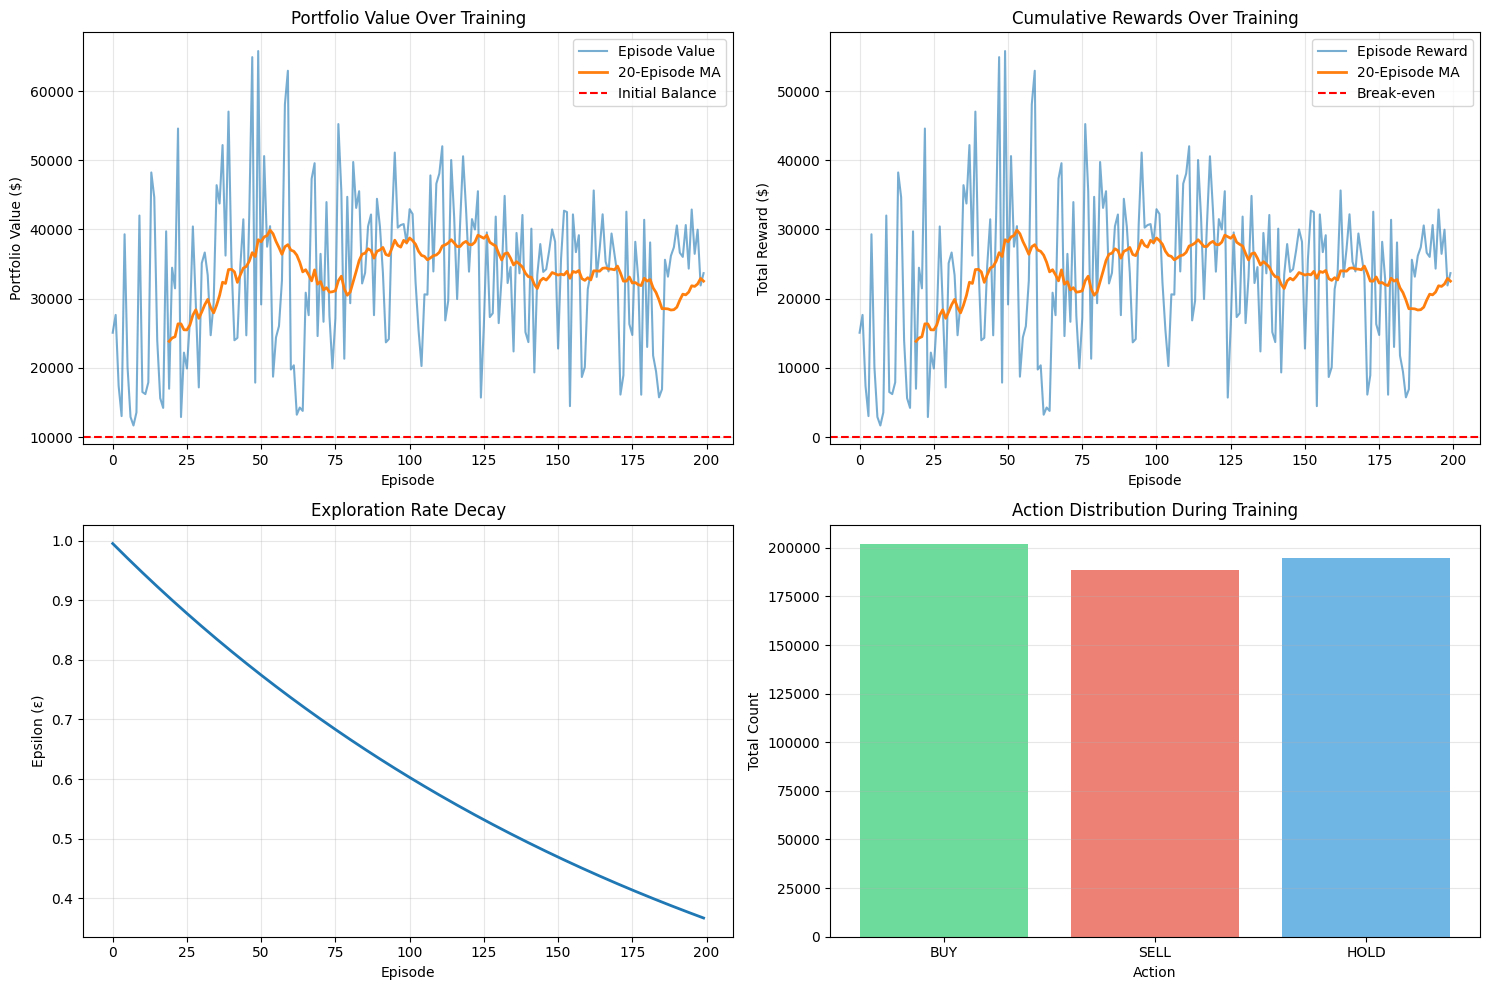


Final Training Statistics:
  Final Portfolio Value: $33693.83
  Return: 236.94%
  Q-table Size: 24835 states
  Total Actions - BUY: 201725, SELL: 188587, HOLD: 194688
Testing Trained Agent...

Test Results:
  Initial Balance: $10000.00
  Final Portfolio Value: $38794.44
  Total Return: 287.94%
  Buy & Hold Return: 24913.63%
  Shares Bought: 940
  Shares Sold: 863
  Final Shares Owned: 77
  Final Cash: $3495.33


In [7]:
# -*- coding: utf-8 -*-
"""Stock_Trading_RL.ipynb

Reinforcement Learning for Stock Trading
==========================================

This notebook demonstrates how to build an RL agent that learns to trade stocks.
The agent will learn when to BUY, SELL, or HOLD based on technical indicators.

**Trading RL Concepts:**
- **Agent**: Trading algorithm that makes buy/sell/hold decisions
- **Environment**: Stock market with price movements and portfolio
- **State**: Current stock features (price, technical indicators, portfolio)
- **Action**: BUY (0), SELL (1), or HOLD (2)
- **Reward**: Portfolio value change (profit/loss)
"""

# =============================================================================
# Cell 1: Import Libraries
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import deque
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")
print("=" * 60)

# =============================================================================
# Cell 2: Load and Explore Dataset
# =============================================================================

# Load the trading dataset
df = pd.read_csv('/content/trading.csv')

print("Dataset Loaded Successfully!")
print("=" * 60)
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head(10))

print(f"\nDataset Info:")
print(df.info())

print(f"\nBasic Statistics:")
print(df.describe())

# =============================================================================
# Cell 3: Data Preprocessing
# =============================================================================

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Convert date column
df['datadate'] = pd.to_datetime(df['datadate'].astype(str), format='%Y%m%d')

# Sort by date and ticker
df = df.sort_values(['tic', 'datadate']).reset_index(drop=True)

# Display unique tickers
print(f"\n\nUnique Stock Tickers: {df['tic'].nunique()}")
print(f"Tickers: {sorted(df['tic'].unique())}")

# Select a single stock for training (you can change this)
STOCK_SYMBOL = 'AAPL'
stock_data = df[df['tic'] == STOCK_SYMBOL].reset_index(drop=True)

print(f"\n\nSelected Stock: {STOCK_SYMBOL}")
print(f"Data points: {len(stock_data)}")
print(f"Date range: {stock_data['datadate'].min()} to {stock_data['datadate'].max()}")

# =============================================================================
# Cell 4: Feature Engineering
# =============================================================================

# Create additional features
stock_data['price_change'] = stock_data['adjcp'].pct_change()
stock_data['price_change'] = stock_data['price_change'].fillna(0)

# Normalize technical indicators to [0, 1] range
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = ['adjcp', 'macd', 'rsi', 'cci', 'adx', 'turbulence']
scaler = MinMaxScaler()

stock_data[features_to_normalize] = scaler.fit_transform(stock_data[features_to_normalize])

print("Feature Engineering Complete!")
print("=" * 60)
print("\nProcessed Data:")
print(stock_data.head())

# Visualize stock price
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(stock_data['datadate'], stock_data['adjcp'])
plt.title(f'{STOCK_SYMBOL} Normalized Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(stock_data['datadate'], stock_data['rsi'])
plt.title(f'{STOCK_SYMBOL} RSI Indicator')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# Cell 5: Define Trading Environment
# =============================================================================

class StockTradingEnv:
    """
    Stock Trading Environment for Reinforcement Learning

    Actions:
        0: BUY (buy 1 share if cash available)
        1: SELL (sell 1 share if shares owned)
        2: HOLD (do nothing)
    """

    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.n_steps = len(data)
        self.n_actions = 3  # BUY, SELL, HOLD

        # State space: [normalized_price, macd, rsi, cci, adx, turbulence, shares_owned, cash_ratio]
        self.n_features = 8

        self.reset()

    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_owned = 0
        self.total_shares_bought = 0
        self.total_shares_sold = 0
        self.portfolio_value = self.initial_balance

        return self._get_state()

    def _get_state(self):
        """Get current state representation"""
        if self.current_step >= len(self.data):
            return np.zeros(self.n_features)

        row = self.data.iloc[self.current_step]

        state = np.array([
            row['adjcp'],        # normalized price
            row['macd'],         # MACD indicator
            row['rsi'],          # RSI indicator
            row['cci'],          # CCI indicator
            row['adx'],          # ADX indicator
            row['turbulence'],   # Market turbulence
            self.shares_owned / 100,  # Normalized shares owned
            self.balance / self.initial_balance  # Cash ratio
        ])

        return state

    def step(self, action):
        """Execute action and return next state, reward, done"""
        if self.current_step >= len(self.data) - 1:
            return self._get_state(), 0, True

        current_price = self.data.iloc[self.current_step]['adjcp']
        # Denormalize price for trading
        current_price_actual = current_price * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

        # Execute action
        if action == 0:  # BUY
            if self.balance >= current_price_actual:
                self.shares_owned += 1
                self.balance -= current_price_actual
                self.total_shares_bought += 1

        elif action == 1:  # SELL
            if self.shares_owned > 0:
                self.shares_owned -= 1
                self.balance += current_price_actual
                self.total_shares_sold += 1

        # action == 2: HOLD (do nothing)

        # Move to next step
        self.current_step += 1
        next_price = self.data.iloc[self.current_step]['adjcp']
        next_price_actual = next_price * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

        # Calculate portfolio value
        old_portfolio_value = self.portfolio_value
        self.portfolio_value = self.balance + self.shares_owned * next_price_actual

        # Reward is the change in portfolio value
        reward = self.portfolio_value - old_portfolio_value

        # Check if episode is done
        done = self.current_step >= len(self.data) - 1

        return self._get_state(), reward, done

    def get_portfolio_value(self):
        """Get current portfolio value"""
        if self.current_step >= len(self.data):
            return self.portfolio_value

        current_price = self.data.iloc[self.current_step]['adjcp']
        current_price_actual = current_price * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
        return self.balance + self.shares_owned * current_price_actual

print("✓ Trading Environment Created!")
print("=" * 60)
print("Environment Details:")
print(f"  - Actions: 3 (BUY, SELL, HOLD)")
print(f"  - State Features: 8")
print(f"  - Initial Balance: $10,000")
print(f"  - Trading Steps: {len(stock_data)}")

# =============================================================================
# Cell 6: Initialize Q-Learning Agent
# =============================================================================

class QLearningAgent:
    """
    Q-Learning Agent for Stock Trading
    Uses discretized states and Q-table
    """

    def __init__(self, n_actions=3, n_bins=10, learning_rate=0.1,
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.01):
        self.n_actions = n_actions
        self.n_bins = n_bins
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-table: discretized state -> action values
        self.q_table = {}

    def discretize_state(self, state):
        """Convert continuous state to discrete bins"""
        discretized = tuple(np.digitize(state, np.linspace(0, 1, self.n_bins)))
        return discretized

    def get_q_values(self, state):
        """Get Q-values for a state (initialize if not exists)"""
        state_key = self.discretize_state(state)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        return self.q_table[state_key]

    def choose_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)  # Explore
        else:
            q_values = self.get_q_values(state)
            return np.argmax(q_values)  # Exploit

    def update(self, state, action, reward, next_state):
        """Update Q-table using Q-learning update rule"""
        state_key = self.discretize_state(state)
        next_state_key = self.discretize_state(next_state)

        # Initialize if needed
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.n_actions)
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = np.zeros(self.n_actions)

        # Q-learning update
        current_q = self.q_table[state_key][action]
        max_next_q = np.max(self.q_table[next_state_key])
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Initialize agent and environment
env = StockTradingEnv(stock_data, initial_balance=10000)
agent = QLearningAgent(n_actions=3, n_bins=10, learning_rate=0.1,
                       discount_factor=0.95, epsilon=1.0)

print("✓ Q-Learning Agent Initialized!")
print("=" * 60)
print("Agent Parameters:")
print(f"  - Learning Rate (α): {agent.alpha}")
print(f"  - Discount Factor (γ): {agent.gamma}")
print(f"  - Initial Epsilon (ε): {agent.epsilon}")
print(f"  - Epsilon Decay: {agent.epsilon_decay}")
print(f"  - State Bins: {agent.n_bins}")

# =============================================================================
# Cell 7: Training Loop
# =============================================================================

# Training parameters
n_episodes = 200
print_every = 20

# Tracking metrics
portfolio_values = []
total_rewards = []
epsilon_history = []
action_counts = {0: [], 1: [], 2: []}  # BUY, SELL, HOLD

print("Starting Training...")
print("=" * 60)

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    episode_actions = {0: 0, 1: 0, 2: 0}

    while not done:
        # Choose and execute action
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)

        # Update Q-table
        agent.update(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        episode_actions[action] += 1

    # Decay epsilon
    agent.decay_epsilon()

    # Record metrics
    final_portfolio_value = env.get_portfolio_value()
    portfolio_values.append(final_portfolio_value)
    total_rewards.append(total_reward)
    epsilon_history.append(agent.epsilon)

    for action in range(3):
        action_counts[action].append(episode_actions[action])

    # Print progress
    if (episode + 1) % print_every == 0:
        avg_portfolio = np.mean(portfolio_values[-print_every:])
        avg_reward = np.mean(total_rewards[-print_every:])
        print(f"Episode {episode + 1}/{n_episodes}")
        print(f"  Avg Portfolio Value: ${avg_portfolio:.2f}")
        print(f"  Avg Reward: ${avg_reward:.2f}")
        print(f"  Epsilon: {agent.epsilon:.4f}")
        print(f"  Q-table Size: {len(agent.q_table)}")
        print(f"  Actions (B/S/H): {episode_actions[0]}/{episode_actions[1]}/{episode_actions[2]}")
        print("-" * 60)

print("\n✓ Training Complete!")

# =============================================================================
# Cell 8: Visualize Training Performance
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Portfolio Value over Episodes
axes[0, 0].plot(portfolio_values, alpha=0.6, label='Episode Value')
axes[0, 0].plot(pd.Series(portfolio_values).rolling(20).mean(),
                linewidth=2, label='20-Episode MA')
axes[0, 0].axhline(y=10000, color='r', linestyle='--', label='Initial Balance')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Portfolio Value ($)')
axes[0, 0].set_title('Portfolio Value Over Training')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Total Rewards
axes[0, 1].plot(total_rewards, alpha=0.6, label='Episode Reward')
axes[0, 1].plot(pd.Series(total_rewards).rolling(20).mean(),
                linewidth=2, label='20-Episode MA')
axes[0, 1].axhline(y=0, color='r', linestyle='--', label='Break-even')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Total Reward ($)')
axes[0, 1].set_title('Cumulative Rewards Over Training')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Epsilon Decay
axes[1, 0].plot(epsilon_history, linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Epsilon (ε)')
axes[1, 0].set_title('Exploration Rate Decay')
axes[1, 0].grid(True, alpha=0.3)

# Action Distribution
action_names = ['BUY', 'SELL', 'HOLD']
action_totals = [np.sum(action_counts[i]) for i in range(3)]
colors = ['#2ecc71', '#e74c3c', '#3498db']
axes[1, 1].bar(action_names, action_totals, color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Action')
axes[1, 1].set_ylabel('Total Count')
axes[1, 1].set_title('Action Distribution During Training')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nFinal Training Statistics:")
print(f"  Final Portfolio Value: ${portfolio_values[-1]:.2f}")
print(f"  Return: {((portfolio_values[-1] / 10000) - 1) * 100:.2f}%")
print(f"  Q-table Size: {len(agent.q_table)} states")
print(f"  Total Actions - BUY: {action_totals[0]}, SELL: {action_totals[1]}, HOLD: {action_totals[2]}")

# =============================================================================
# Cell 9: Test the Trained Agent
# =============================================================================

print("Testing Trained Agent...")
print("=" * 60)

# Reset environment and agent (no exploration)
test_epsilon = agent.epsilon
agent.epsilon = 0.0  # Pure exploitation

state = env.reset()
done = False
actions_taken = []
portfolio_history = []
price_history = []

while not done:
    action = agent.choose_action(state)
    actions_taken.append(action)
    portfolio_history.append(env.get_portfolio_value())
    price_history.append(stock_data.iloc[env.current_step]['adjcp'])

    state, reward, done = env.step(action)

# Restore epsilon
agent.epsilon = test_epsilon

# Calculate metrics
final_value = env.get_portfolio_value()
total_return = ((final_value / env.initial_balance) - 1) * 100
buy_and_hold_return = ((price_history[-1] / price_history[0]) - 1) * 100

print(f"\nTest Results:")
print(f"  Initial Balance: ${env.initial_balance:.2f}")
print(f"  Final Portfolio Value: ${final_value:.2f}")
print(f"  Total Return: {total_return:.2f}%")
print(f"  Buy & Hold Return: {buy_and_hold_return:.2f}%")
print(f"  Shares Bought: {env.total_shares_bought}")
print(f"  Shares Sold: {env.total_shares_sold}")
print(f"  Final Shares Owned: {env.shares_owned}")
print(f"  Final Cash: ${env.balance:.2f}")



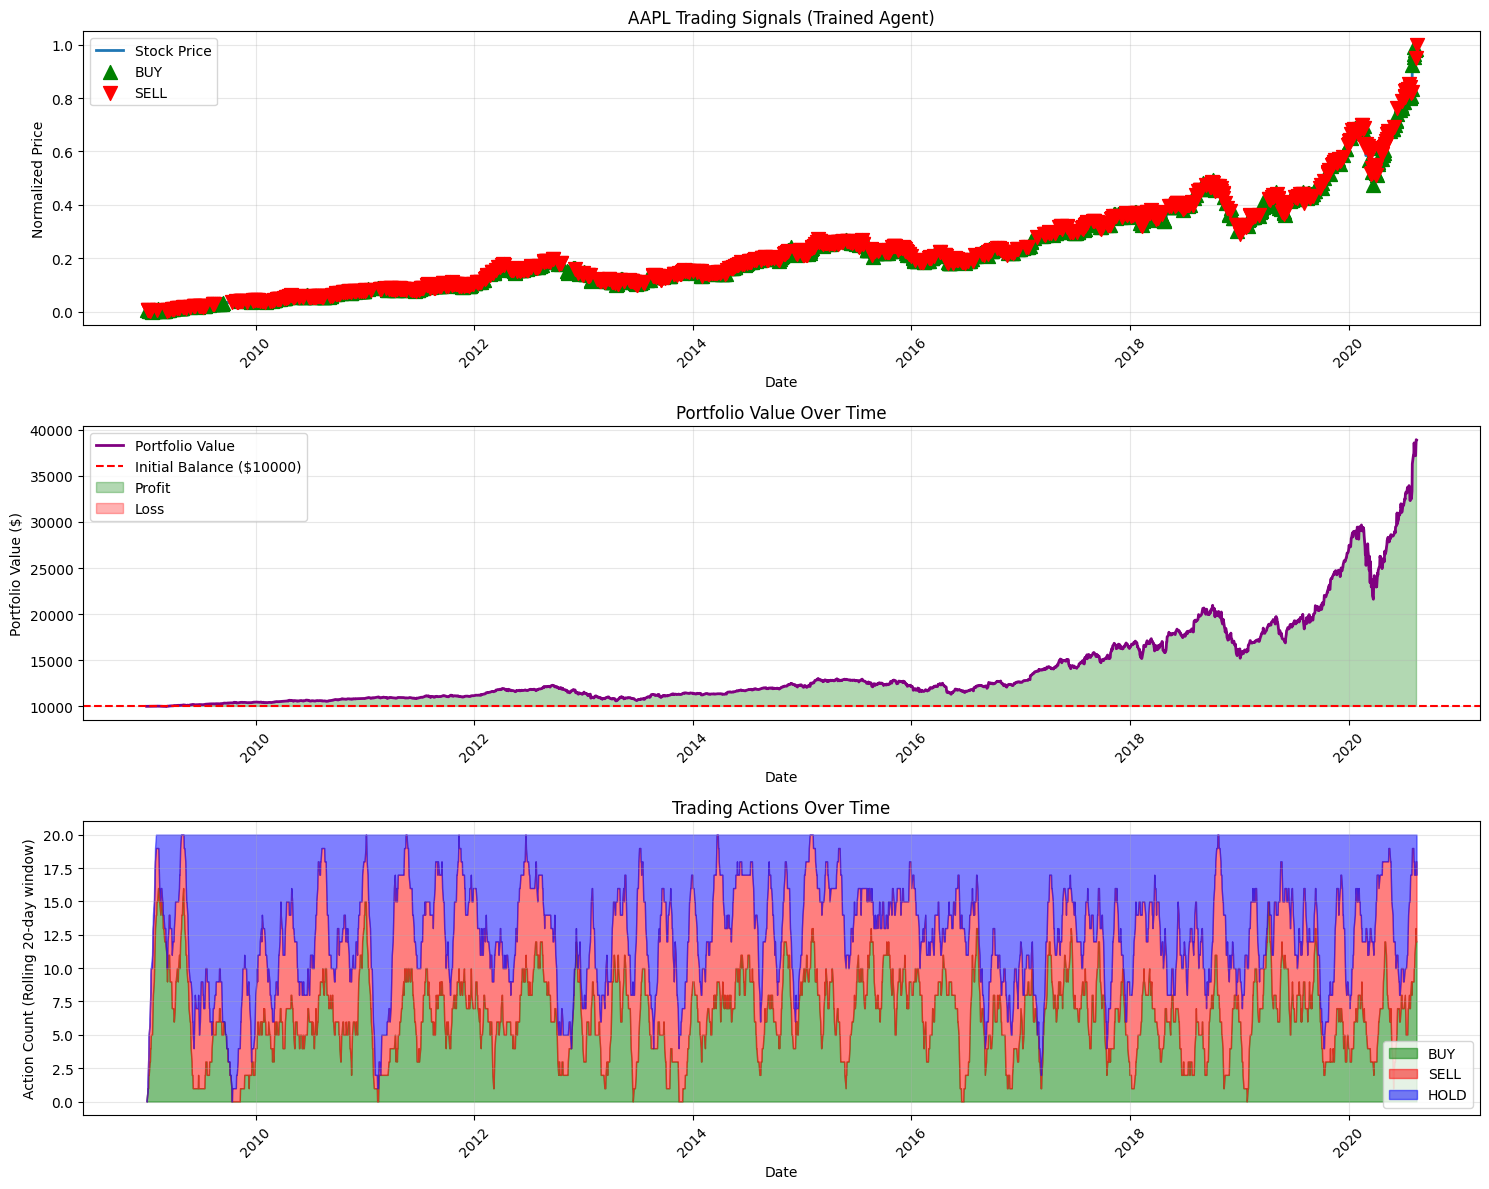


FINAL PERFORMANCE SUMMARY

📊 Portfolio Metrics:
  Initial Investment: $10,000.00
  Final Portfolio Value: $38,794.44
  Absolute Profit/Loss: $28,794.44
  Return on Investment: 287.94%
  Max Portfolio Value: $38,918.82
  Min Portfolio Value: $9,975.71
  Max Drawdown: 74.37%

📈 Trading Statistics:
  Total Trades: 1803
  Shares Bought: 940
  Shares Sold: 863
  Final Position: 77 shares
  Cash Remaining: $3,495.33

🎯 Strategy Performance:
  Agent Return: 287.94%
  Buy & Hold Return: 24913.63%
  Outperformance: -24625.68%

🧠 Learning Statistics:
  Q-table Size: 24843 states
  Training Episodes: 200
  Final Epsilon: 0.3670



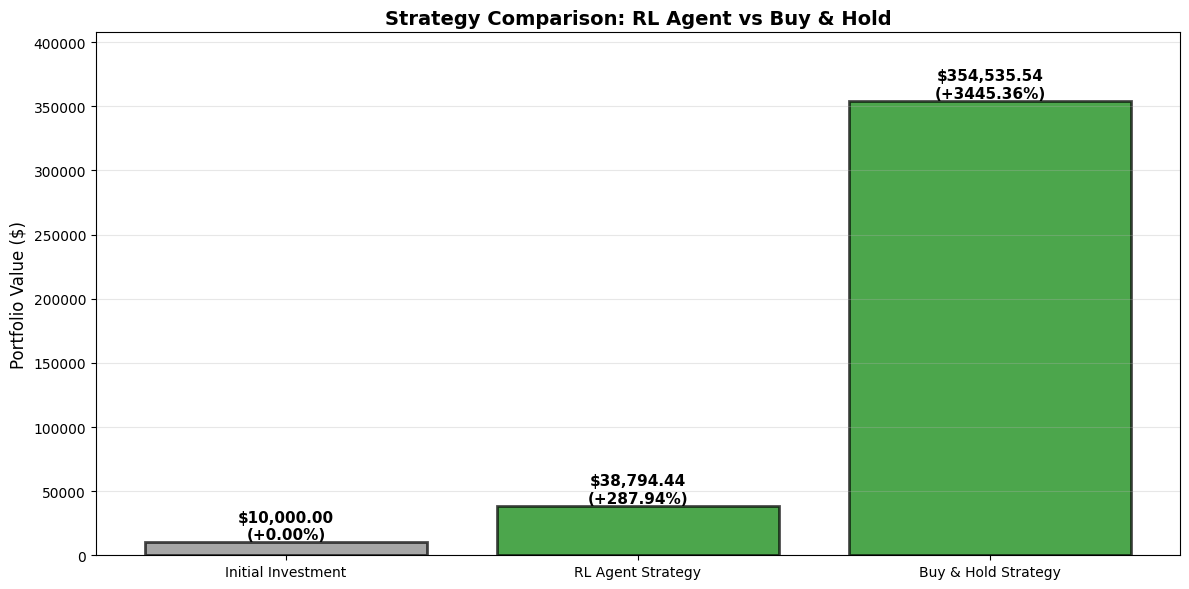


Strategy Comparison:
  Buy & Hold Final Value: $354,535.54
  Buy & Hold Return: 24913.63%
  RL Agent Final Value: $38,794.44
  RL Agent Return: 287.94%
  ✗ RL Agent UNDERPERFORMED Buy & Hold by $315,741.09

Sample Trading Log:
        date     price  portfolio_value  action action_name
0 2009-01-02  0.003994     10000.000000       0         BUY
1 2009-01-05  0.005213     10000.547143       1        SELL
2 2009-01-06  0.004717     10000.547143       1        SELL
3 2009-01-07  0.004077     10000.547143       0         BUY
4 2009-01-08  0.004615     10000.788571       1        SELL
5 2009-01-09  0.003940     10000.788571       0         BUY
6 2009-01-12  0.003329     10000.514286       1        SELL
7 2009-01-13  0.003027     10000.514286       0         BUY
8 2009-01-14  0.002269     10000.174286       1        SELL
9 2009-01-15  0.001649     10000.174286       0         BUY

✓ Results saved to 'trading_results.csv'

NOTEBOOK COMPLETE!

🎉 You have successfully trained an RL agent for s

In [10]:
# Cell 10: Visualize Trading Strategy
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Stock Price with Buy/Sell Signals
dates = stock_data['datadate'].values
buy_signals = [i for i, a in enumerate(actions_taken) if a == 0]
sell_signals = [i for i, a in enumerate(actions_taken) if a == 1]

axes[0].plot(dates[:-1], price_history, label='Stock Price', linewidth=2)
if buy_signals:
    axes[0].scatter(dates[buy_signals], [price_history[i] for i in buy_signals],
                   color='green', marker='^', s=100, label='BUY', zorder=5)
if sell_signals:
    axes[0].scatter(dates[sell_signals], [price_history[i] for i in sell_signals],
                   color='red', marker='v', s=100, label='SELL', zorder=5)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Normalized Price')
axes[0].set_title(f'{STOCK_SYMBOL} Trading Signals (Trained Agent)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Portfolio Value Over Time
axes[1].plot(dates[:-1], portfolio_history, linewidth=2, color='purple', label='Portfolio Value')
axes[1].axhline(y=env.initial_balance, color='r', linestyle='--',
               label=f'Initial Balance (${env.initial_balance})')
axes[1].fill_between(dates[:-1], env.initial_balance, portfolio_history,
                     where=np.array(portfolio_history) >= env.initial_balance,
                     alpha=0.3, color='green', label='Profit')
axes[1].fill_between(dates[:-1], env.initial_balance, portfolio_history,
                     where=np.array(portfolio_history) < env.initial_balance,
                     alpha=0.3, color='red', label='Loss')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Portfolio Value ($)')
axes[1].set_title('Portfolio Value Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Action Distribution Over Time
action_window = 20
buy_counts = [sum(1 for a in actions_taken[max(0, i-action_window):i] if a == 0)
              for i in range(len(actions_taken))]
sell_counts = [sum(1 for a in actions_taken[max(0, i-action_window):i] if a == 1)
               for i in range(len(actions_taken))]
hold_counts = [sum(1 for a in actions_taken[max(0, i-action_window):i] if a == 2)
               for i in range(len(actions_taken))]

axes[2].fill_between(dates[:-1], 0, buy_counts, alpha=0.5, color='green', label='BUY')
axes[2].fill_between(dates[:-1], buy_counts, [b+s for b, s in zip(buy_counts, sell_counts)],
                    alpha=0.5, color='red', label='SELL')
axes[2].fill_between(dates[:-1], [b+s for b, s in zip(buy_counts, sell_counts)],
                    [b+s+h for b, s, h in zip(buy_counts, sell_counts, hold_counts)],
                    alpha=0.5, color='blue', label='HOLD')
axes[2].set_xlabel('Date')
axes[2].set_ylabel(f'Action Count (Rolling {action_window}-day window)')
axes[2].set_title('Trading Actions Over Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# Cell 11: Performance Metrics Summary
# =============================================================================

print("\n" + "=" * 60)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 60)

# Calculate additional metrics
sharpe_ratio = np.mean(total_rewards) / (np.std(total_rewards) + 1e-6)
max_portfolio = max(portfolio_history)
min_portfolio = min(portfolio_history)
max_drawdown = ((max_portfolio - min_portfolio) / max_portfolio) * 100

print(f"\n📊 Portfolio Metrics:")
print(f"  Initial Investment: ${env.initial_balance:,.2f}")
print(f"  Final Portfolio Value: ${final_value:,.2f}")
print(f"  Absolute Profit/Loss: ${final_value - env.initial_balance:,.2f}")
print(f"  Return on Investment: {total_return:.2f}%")
print(f"  Max Portfolio Value: ${max_portfolio:,.2f}")
print(f"  Min Portfolio Value: ${min_portfolio:,.2f}")
print(f"  Max Drawdown: {max_drawdown:.2f}%")

print(f"\n📈 Trading Statistics:")
print(f"  Total Trades: {env.total_shares_bought + env.total_shares_sold}")
print(f"  Shares Bought: {env.total_shares_bought}")
print(f"  Shares Sold: {env.total_shares_sold}")
print(f"  Final Position: {env.shares_owned} shares")
print(f"  Cash Remaining: ${env.balance:,.2f}")

print(f"\n🎯 Strategy Performance:")
print(f"  Agent Return: {total_return:.2f}%")
print(f"  Buy & Hold Return: {buy_and_hold_return:.2f}%")
print(f"  Outperformance: {total_return - buy_and_hold_return:.2f}%")

print(f"\n🧠 Learning Statistics:")
print(f"  Q-table Size: {len(agent.q_table)} states")
print(f"  Training Episodes: {n_episodes}")
print(f"  Final Epsilon: {agent.epsilon:.4f}")

print("\n" + "=" * 60)

# =============================================================================
# Cell 12: Compare with Buy-and-Hold Strategy
# =============================================================================

# Calculate buy-and-hold performance
initial_price = price_history[0] * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
final_price = price_history[-1] * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]
shares_buyhold = env.initial_balance / initial_price
buyhold_final_value = shares_buyhold * final_price

# Comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

x = ['Initial Investment', 'RL Agent Strategy', 'Buy & Hold Strategy']
y = [env.initial_balance, final_value, buyhold_final_value]
colors_bar = ['gray', 'green' if final_value > env.initial_balance else 'red',
              'green' if buyhold_final_value > env.initial_balance else 'red']

bars = ax.bar(x, y, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, y)):
    height = bar.get_height()
    return_pct = ((value / env.initial_balance) - 1) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'${value:,.2f}\n({return_pct:+.2f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.set_title('Strategy Comparison: RL Agent vs Buy & Hold', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(y) * 1.15)

plt.tight_layout()
plt.show()

print("\nStrategy Comparison:")
print(f"  Buy & Hold Final Value: ${buyhold_final_value:,.2f}")
print(f"  Buy & Hold Return: {buy_and_hold_return:.2f}%")
print(f"  RL Agent Final Value: ${final_value:,.2f}")
print(f"  RL Agent Return: {total_return:.2f}%")

if final_value > buyhold_final_value:
    print(f"  ✓ RL Agent OUTPERFORMED Buy & Hold by ${final_value - buyhold_final_value:,.2f}")
else:
    print(f"  ✗ RL Agent UNDERPERFORMED Buy & Hold by ${buyhold_final_value - final_value:,.2f}")

# =============================================================================
# Cell 13: Save Results
# =============================================================================

# Create results dataframe
results_df = pd.DataFrame({
    'date': dates[:-1],
    'price': price_history,
    'portfolio_value': portfolio_history,
    'action': actions_taken
})

results_df['action_name'] = results_df['action'].map({0: 'BUY', 1: 'SELL', 2: 'HOLD'})

print("\nSample Trading Log:")
print(results_df[results_df['action'] != 2].head(10))  # Show first 10 trades

# Save to CSV
results_df.to_csv('trading_results.csv', index=False)
print("\n✓ Results saved to 'trading_results.csv'")

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE!")
print("=" * 60)
print("\n🎉 You have successfully trained an RL agent for stock trading!")
print("📚 Key Takeaways:")
print("  - RL agents can learn trading strategies through trial and error")
print("  - Q-learning uses a Q-table to store action values for each state")
print("  - Exploration (ε-greedy) helps discover better strategies")
print("  - Technical indicators provide valuable state information")
print("\n💡 Next Steps:")
print("  - Try different stocks by changing STOCK_SYMBOL")
print("  - Experiment with hyperparameters (learning rate, epsilon, etc.)")
print("  - Add more technical indicators as features")
print("  - Implement more sophisticated RL algorithms (DQN, A3C, PPO)")
print("=" * 60)
